# CSCA 5642 Week 4: NLP Disaster Tweets Kaggle Mini-Project

## Introduction

This project uses a recurrent neural network to determine if tweets are about real disasters or not. The dataset consists of 10,000 tweets that were hand classified to 1 if the tweet is about a real disaster, 0 if not. It is provided by Kaggle, which can be downloaded here [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview). 
The link to my github repository is [CSCA5642 Module 4](https://github.com/l2chu/CSCA_5642_module4).


## Import Libraries

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU for you...")

We got a GPU


## Import Dataset

In [5]:
train_path = 'train.csv'
test_path = 'test.csv'
sample_submission_file = 'sample_submission.csv'

In [6]:
df_train = pd.read_csv(train_path)
print('Shape of Training DataFrame',df_train.shape)
df_test = pd.read_csv(test_path)
print('Shape of Test DataFrame',df_test.shape)

df_train.head()

Shape of Training DataFrame (7613, 5)
Shape of Test DataFrame (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## EDA
Now let's see the distribution of the features.

In [8]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')
print(f'Number of unique values in text = {df_train["text"].nunique()} (Training) - {df_test["text"].nunique()} (Test)')

Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)
Number of unique values in text = 7503 (Training) - 3243 (Test)


There are too many unique locations which means it will not help with training the model, so it should not be used as a feature.\
Let's take a look at the target values.

In [9]:
label_counts = df_train["target"].value_counts()
label_counts

0    4342
1    3271
Name: target, dtype: int64

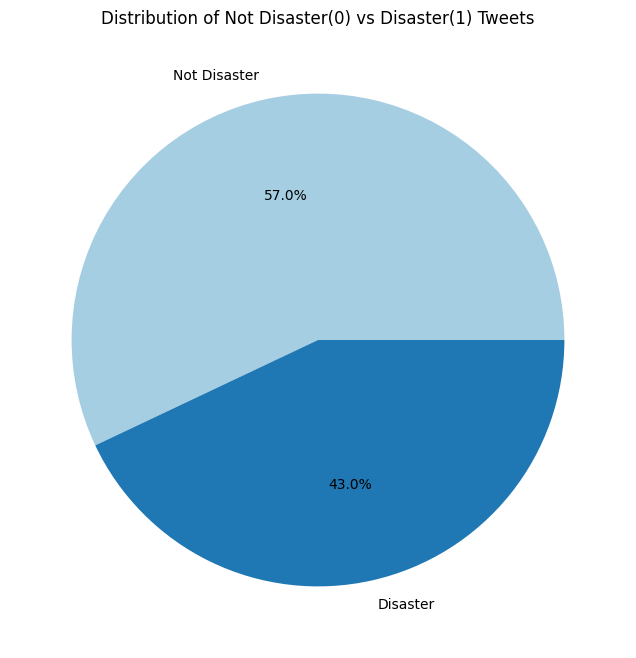

In [10]:
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of Not Disaster(0) vs Disaster(1) Tweets')
plt.show()

Let's look at the average length of each tweet 

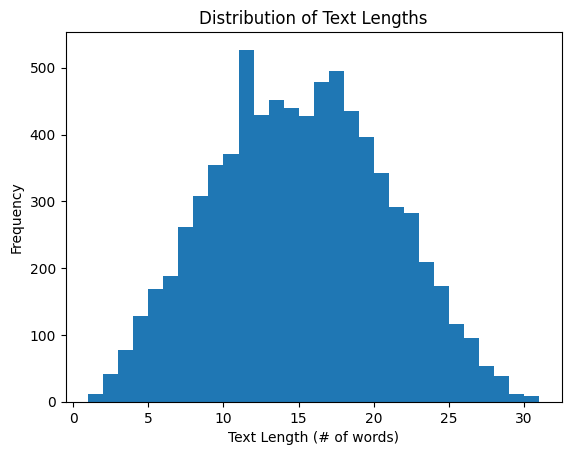

In [16]:
text_lengths = [len(text.split()) for text in df_train["text"]]

# Plot histogram
plt.hist(text_lengths, bins=30)
plt.xlabel("Text Length (# of words)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

## Data Cleaning


The text data has lots of punctuation and to make all unique words the same token, we convert it all to lower case.

In [9]:
def clean(s):
    s = s.translate(str.maketrans('', '', string.punctuation))
    s= s.lower()
    return s

In [10]:
df_train['text'] = df_train['text'].astype(str)
df_train['text'] = df_train['text'].map(lambda s: clean(s))

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


## Embedding and Tokenization

I am choosing to use GLoVe for Embedding because it works better with my pre trained embeddings. Word2Vec would be less optimal since I am not processing dynamic language or custom jargon.

In [12]:
# Load GloVe embeddings into a dictionary
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector
    return embeddings_index

# Load 100-dimensional GloVe embeddings
glove_file = "glove.6B/glove.6B.100d.txt"
embeddings_index = load_glove_embeddings(glove_file)

In [13]:
print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [119]:
# Tokenize the Text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["text"])
word_index = tokenizer.word_index

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df_train["text"])
max_length = 30 # since most of the tweets are not longer than 30 words
padded_sequences = pad_sequences(sequences, maxlen=max_length)

print(f"Vocabulary Size: {len(word_index)}")

# Create GloVe Embedding Matrix
embedding_dim = 100  # Using GloVe 100D embeddings
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

print("Embedding Matrix Shape:", embedding_matrix.shape)

Vocabulary Size: 22697
Embedding Matrix Shape: (22698, 100)


## Model Architecture

In [22]:
labels = np.array(df_train["target"])
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, 
                                                  labels, 
                                                  test_size = 0.2, 
                                                  random_state =3, 
                                                  stratify=labels)

In [38]:
def plot_history(history):

    plt.plot(history.history['accuracy'], color='blue', label="train")
    plt.plot( history.history['val_accuracy'], color='red', label="validation")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

    plt.plot(history.history['loss'], color='blue', label="train")
    plt.plot(history.history['val_loss'], color='red', label="validation")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

### LSTM Model
For the first basic model, I will use LSTM with just one layer.

In [34]:
lstm_model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,
              weights=[embedding_matrix]),
    
    LSTM(128),
    Dense(64, activation="relu"),
    Dropout(0.5), 
    Dense(1, activation="sigmoid")  
])
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     2,269,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,800 (8.66 MB)

 Trainable params: 2,269,800 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
lstm_hist = lstm_model.fit(X_train, y_train, 
                           epochs=10, 
                           batch_size=32,
                           validation_data=(X_val, y_val))

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9969 - loss: 0.0065 - val_accuracy: 0.7925 - val_loss: 1.6951
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9948 - loss: 0.0164 - val_accuracy: 0.7557 - val_loss: 1.4452
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9941 - loss: 0.0135 - val_accuracy: 0.7781 - val_loss: 1.4755
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9962 - loss: 0.0072 - val_accuracy: 0.7676 - val_loss: 1.4984
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9969 - loss: 0.0065 - val_accuracy: 0.7722 - val_loss: 1.6334
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9960 - loss: 0.0065 - val_accuracy: 0.7722 - val_loss: 1.7065
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9961 - loss: 0.0067 - val_accuracy: 0.7728 - val_loss: 1.8314
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9956 - loss: 0.0062 - val_accuracy:

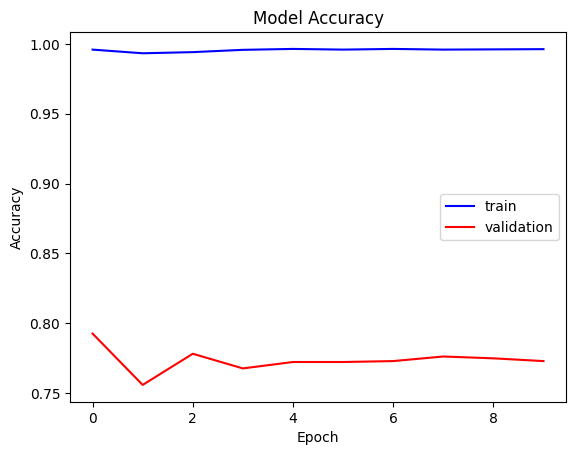

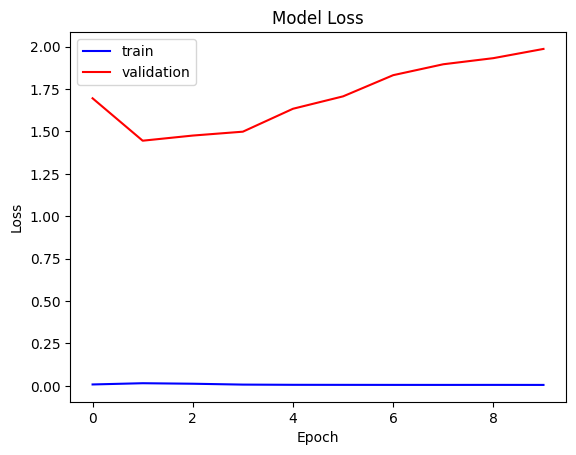

In [39]:
plot_history(lstm_hist)

It looks like the model definitely overfit because training accuracy is nearly 100% with no loss, but validation data has a very high loss. To fix the overfitting, I added a global max pooling after the LSTM layer to reduce dimensionality and lower overfitting.

In [47]:
lstm_model_v2 = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,
              weights=[embedding_matrix]),
    
    LSTM(128, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(64, activation="relu"),
    Dropout(0.5), 
    Dense(1, activation="sigmoid")  
])
lstm_model_v2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model_v2.summary()
callback = EarlyStopping(patience=8,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │     2,269,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,800 (8.66 MB)

 Trainable params: 2,269,800 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
lstm_hist_v2 = lstm_model_v2.fit(X_train, y_train,
                                 epochs=20, 
                                 batch_size=32,
                                 validation_data=(X_val, y_val),
                                 callbacks=[callback])

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7262 - loss: 0.5562 - val_accuracy: 0.8056 - val_loss: 0.4289
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8384 - loss: 0.3939 - val_accuracy: 0.8155 - val_loss: 0.4282
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8698 - loss: 0.3245 - val_accuracy: 0.8096 - val_loss: 0.4472
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9144 - loss: 0.2201 - val_accuracy: 0.7892 - val_loss: 0.5043
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9622 - loss: 0.1091 - val_accuracy: 0.7997 - val_loss: 0.6446
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9822 - loss: 0.0561 - val_accuracy: 0.7912 - val_loss: 0.7409
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9879 - loss: 0.0370 - val_accuracy: 0.7748 - val_loss: 0.9665
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9943 - loss: 0.0211 - val_accur

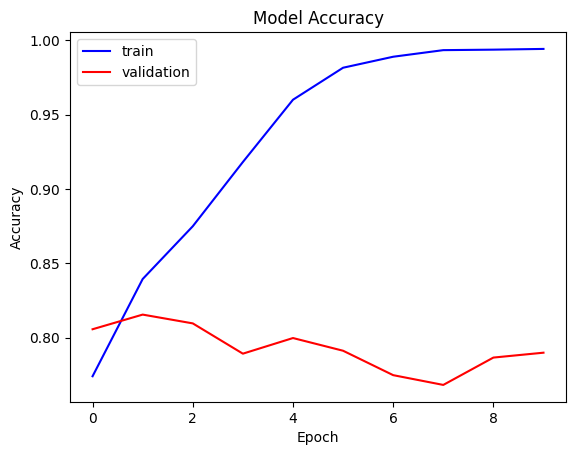

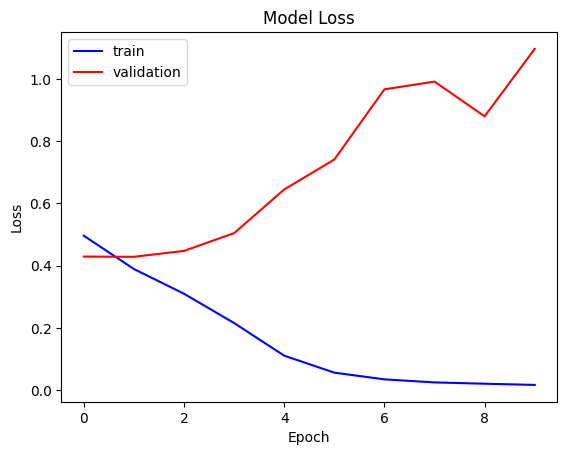

In [50]:
plot_history(lstm_hist_v2)

It looks like early stopping was too late, so I decreased the patience. It looks much better, but is still overfitting, so I increased the dropout to 0.6 and decreased the optimizer learning rate.

In [104]:
lstm_model_v3 = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,
              weights=[embedding_matrix]),
    
    LSTM(128, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(128, activation="relu"),
    Dropout(0.6), 
    Dense(1, activation="sigmoid")  
])
lstm_model_v3.compile(optimizer=Adam(learning_rate=0.00009), loss="binary_crossentropy", metrics=["accuracy"])
lstm_model_v3.summary()
callback = EarlyStopping(patience=5,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ ?                      │     2,269,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_34         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,800 (8.66 MB)

 Trainable params: 2,269,800 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
lstm_hist_v3 = lstm_model_v3.fit(X_train, y_train,
                                 epochs=20, 
                                 batch_size=16,
                                 validation_data=(X_val, y_val),
                                 callbacks=[callback])

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6249 - loss: 0.6460 - val_accuracy: 0.7794 - val_loss: 0.4996
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7903 - loss: 0.4818 - val_accuracy: 0.7912 - val_loss: 0.4636
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8090 - loss: 0.4391 - val_accuracy: 0.7971 - val_loss: 0.4360
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8311 - loss: 0.4068 - val_accuracy: 0.8037 - val_loss: 0.4337
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8315 - loss: 0.3975 - val_accuracy: 0.8056 - val_loss: 0.4298
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8401 - loss: 0.3844 - val_accuracy: 0.8142 - val_loss: 0.4254
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8611 - loss: 0.3481 - val_accuracy: 0.8135 - val_loss: 0.4247
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8638 - loss: 0.3478 - val_accuracy:

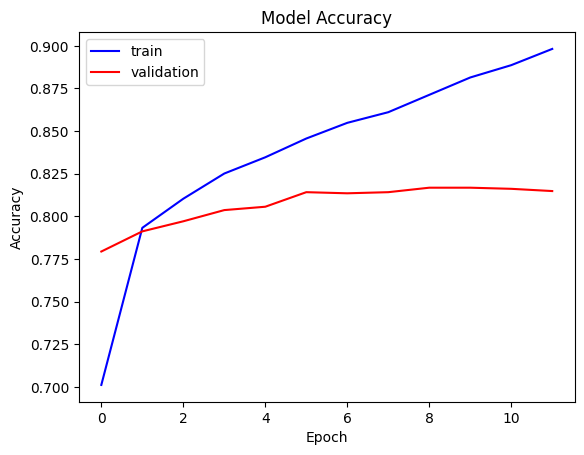

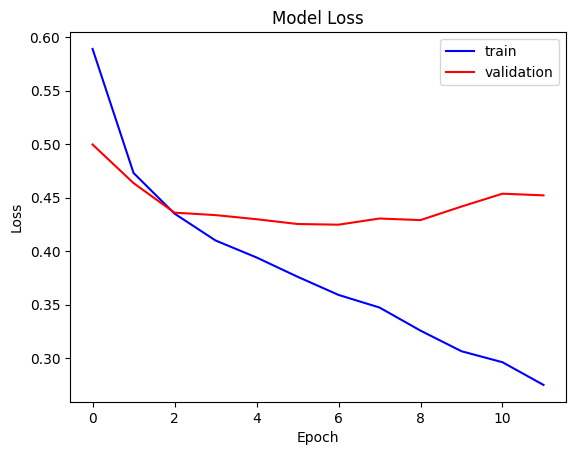

In [106]:
plot_history(lstm_hist_v3)

## Results and Analysis

The improvement is minimal, so LSTM model is probably not the best choice for this problem. Let's try using GRU model instead.

In [111]:
gru_model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,
              weights=[embedding_matrix]),
    
    GRU(128, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(128, activation="relu"),
    Dropout(0.6), 
    Dense(1, activation="sigmoid")  
])
gru_model.compile(optimizer=Adam(learning_rate=0.00009), loss="binary_crossentropy", metrics=["accuracy"])
gru_model.summary()
callback = EarlyStopping(patience=5,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_38 (Embedding)        │ ?                      │     2,269,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_37         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,800 (8.66 MB)

 Trainable params: 2,269,800 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
gru_hist = gru_model.fit(X_train, y_train,
                                 epochs=20, 
                                 batch_size=8,
                                 validation_data=(X_val, y_val),
                                 callbacks=[callback])

Epoch 1/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6030 - loss: 0.6624 - val_accuracy: 0.7636 - val_loss: 0.4935
Epoch 2/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7913 - loss: 0.4723 - val_accuracy: 0.7971 - val_loss: 0.4477
Epoch 3/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8205 - loss: 0.4221 - val_accuracy: 0.7971 - val_loss: 0.4325
Epoch 4/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8333 - loss: 0.3990 - val_accuracy: 0.8056 - val_loss: 0.4256
Epoch 5/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8374 - loss: 0.3801 - val_accuracy: 0.8030 - val_loss: 0.4306
Epoch 6/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8570 - loss: 0.3544 - val_accuracy: 0.8102 - val_loss: 0.4207
Epoch 7/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8675 - loss: 0.3370 - val_accuracy: 0.8109 - val_loss: 0.4227
Epoch 8/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8825 - loss: 0.3051 - val_accura

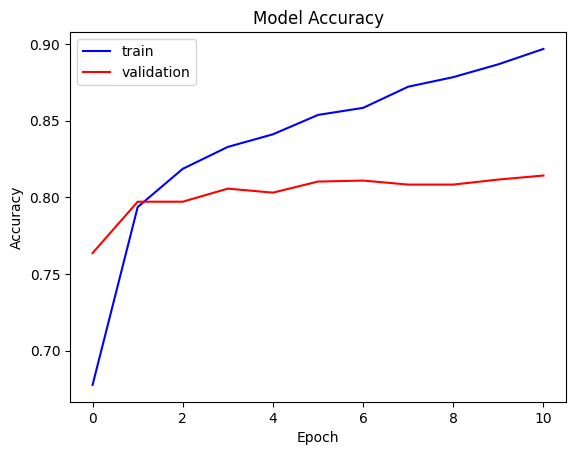

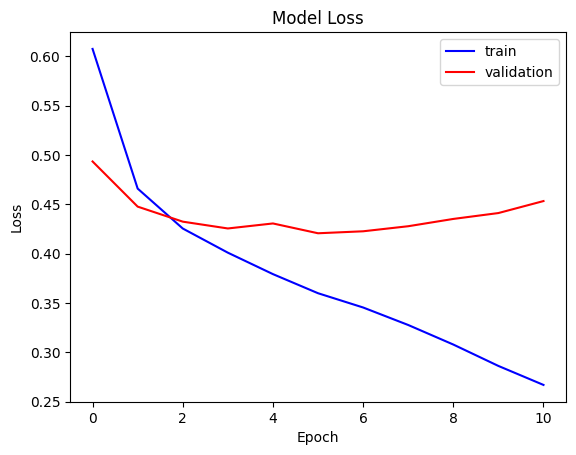

In [113]:
plot_history(gru_hist)

In [116]:
gru_model_v2 = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim,
              weights=[embedding_matrix]),
    
    GRU(128, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(128, activation="relu"),
    Dropout(0.5), 
    Dense(1, activation="sigmoid")  
])
gru_model_v2.compile(optimizer=Adam(learning_rate=0.00009), loss="binary_crossentropy", metrics=["accuracy"])
gru_model_v2.summary()
callback = EarlyStopping(patience=5,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_40 (Embedding)        │ ?                      │     2,269,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_39         │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,800 (8.66 MB)

 Trainable params: 2,269,800 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
gru_hist_v2 = gru_model_v2.fit(X_train, y_train,
                                 epochs=20, 
                                 batch_size=8,
                                 validation_data=(X_val, y_val),
                                 callbacks=[callback])

Epoch 1/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6400 - loss: 0.6297 - val_accuracy: 0.7800 - val_loss: 0.4748
Epoch 2/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7944 - loss: 0.4553 - val_accuracy: 0.7978 - val_loss: 0.4404
Epoch 3/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8181 - loss: 0.4239 - val_accuracy: 0.7997 - val_loss: 0.4253
Epoch 4/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8367 - loss: 0.3955 - val_accuracy: 0.8070 - val_loss: 0.4221
Epoch 5/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8475 - loss: 0.3748 - val_accuracy: 0.8024 - val_loss: 0.4199
Epoch 6/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8549 - loss: 0.3534 - val_accuracy: 0.8096 - val_loss: 0.4204
Epoch 7/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8669 - loss: 0.3325 - val_accuracy: 0.8076 - val_loss: 0.4284
Epoch 8/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8732 - loss: 0.3145 - val_accu

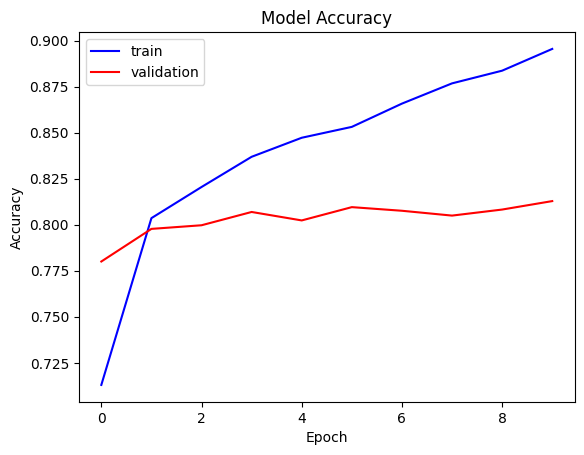

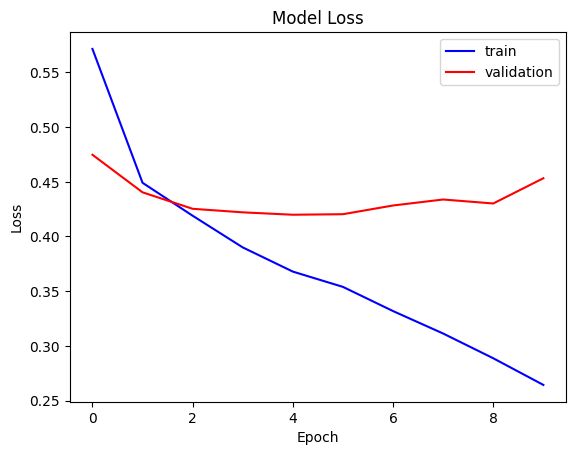

In [118]:
plot_history(gru_hist_v2)

## Predict Test tweets with the best performing model and create the csv submission file

In [124]:
# Preprocess test text
X_test_sequences = tokenizer.texts_to_sequences(df_test["text"])
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)


test_preds_prob = lstm_model_v2.predict(X_test_padded)
test_preds = (test_preds_prob > 0.5).astype(int)

submission = pd.read_csv(sample_submission_file)
submission['target'] = test_preds

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [128]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [126]:
submission.to_csv('kaggle_submission.csv', index=False)

## Conclusion
The best performing model with highest validation accuracy and lowest validation loss is LTSM (val_accuracy: 0.8155 - val_loss: 0.4282). \
I started playing around with all the hyperparameters, such as reducing the recurrent layer size from 128 to 64, lower the learning rate, increase the dropout, and decrease batch size. From all the tuning, I realized that there was not much change, so I decided to stop. In the future, I could try a bidirectional recurrent layer, or more recurrent layers.

## References
https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets \
https://www.kaggle.com/c/nlp-getting-started/overview \
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert